## Reddit API and NLP to Determine Classificiation

### Can we use the predictive powers of modeling in combination with Natural Language Processing Techniques to classify Reddit Posts? 

In this project we are looking to predict whether a group of advice falls under Ethical Life Tips or Unethical Life tips

- We will collect data using API request
- Cleaning the data using Beautiful Soup and Regex functions
- Using CountVectorizer and TfidfVectorizers to separate our title text into data we can model
- Using LogisticRegression and RandomForestClassifer to model the data and predict it. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup     
import re
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lpt = pd.read_csv("./LPT.csv")
ulpt = pd.read_csv("./ULPT.csv")

In [3]:
lpt.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,"LPT: Night before heavy snowfall, put a party ...",NaN,LifeProTips,1542598841,djcoinmoney,4,1,True,2018-11-18
1,1,Google drive saves automatically so if you’re ...,[removed],LifeProTips,1542598953,VolcanicKirby2,2,1,True,2018-11-18
2,2,"LPT: During camping or power outage, turn the ...",NaN,LifeProTips,1542600451,AThinRedLine,278,1,True,2018-11-18
3,3,LPT: Write and start your New Year's Resolutio...,[removed],LifeProTips,1542600574,johnald03,2,1,True,2018-11-18
4,4,"LPT: When reflecting upon yourself, ignore the...",NaN,LifeProTips,1542601087,EmeryBall,1,1,True,2018-11-18


In [4]:
lpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977 entries, 0 to 4976
Data columns (total 10 columns):
Unnamed: 0      4977 non-null int64
title           4977 non-null object
selftext        3379 non-null object
subreddit       4977 non-null object
created_utc     4977 non-null int64
author          4977 non-null object
num_comments    4977 non-null int64
score           4977 non-null int64
is_self         4977 non-null bool
timestamp       4977 non-null object
dtypes: bool(1), int64(4), object(5)
memory usage: 354.9+ KB


### Lets combine the two data sets so we can work with it

In [5]:
tips = pd.concat([lpt, ulpt], ignore_index="True")

In [6]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9933 entries, 0 to 9932
Data columns (total 10 columns):
Unnamed: 0      9933 non-null int64
title           9933 non-null object
selftext        6038 non-null object
subreddit       9933 non-null object
created_utc     9933 non-null int64
author          9933 non-null object
num_comments    9933 non-null int64
score           9933 non-null int64
is_self         9933 non-null bool
timestamp       9933 non-null object
dtypes: bool(1), int64(4), object(5)
memory usage: 708.2+ KB


In [7]:
tips["length"] = tips["title"].apply(len)

In [8]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9933 entries, 0 to 9932
Data columns (total 11 columns):
Unnamed: 0      9933 non-null int64
title           9933 non-null object
selftext        6038 non-null object
subreddit       9933 non-null object
created_utc     9933 non-null int64
author          9933 non-null object
num_comments    9933 non-null int64
score           9933 non-null int64
is_self         9933 non-null bool
timestamp       9933 non-null object
length          9933 non-null int64
dtypes: bool(1), int64(5), object(5)
memory usage: 785.8+ KB


### EDA to see the distribution of a few important features in the dataset

1. Examine length to see how long the average post is over a course of distribution
2. The length is an important factor to look at as well
3. How popular a post is often determined by the number of comments too 

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


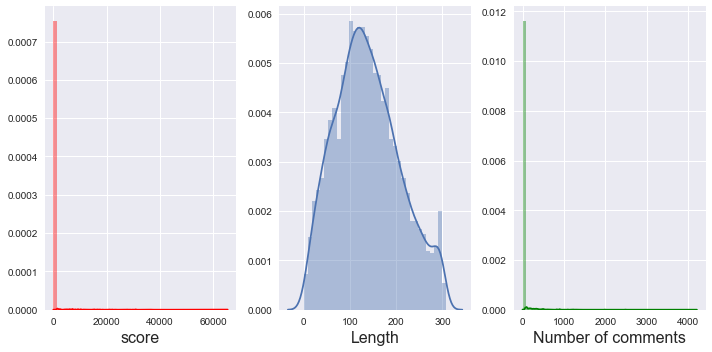

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.distplot(tips['score'],ax=axes[0], color='red')
sns.distplot(tips['length'],ax=axes[1])
sns.distplot(tips['num_comments'], ax=axes[2], color='green')
axes[0].set_xlabel('score', fontdict={'fontsize': 16})
axes[1].set_xlabel('Length', fontdict={'fontsize': 16})
axes[2].set_xlabel('Number of comments', fontdict={'fontsize': 16})

plt.tight_layout()

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


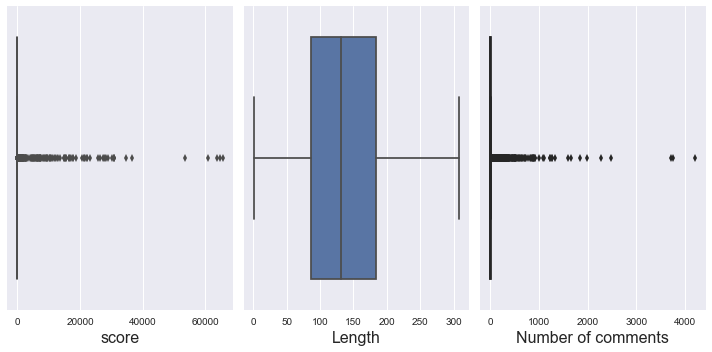

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(tips['score'],ax=axes[0], color='red')
sns.boxplot(tips['length'],ax=axes[1])
sns.boxplot(tips['num_comments'], ax=axes[2], color='green')
axes[0].set_xlabel('score', fontdict={'fontsize': 16})
axes[1].set_xlabel('Length', fontdict={'fontsize': 16})
axes[2].set_xlabel('Number of comments', fontdict={'fontsize': 16})

plt.tight_layout()

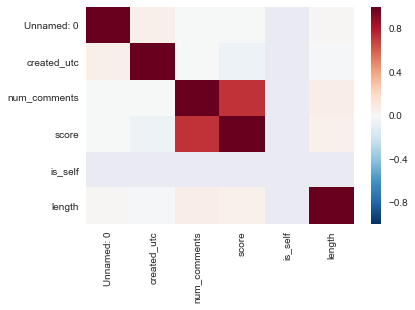

In [11]:
corr= tips.corr()
sns.heatmap(corr)

### We are going to binarize the two different subreddits so we can evaluate it

1 will be Lifeprotip - What we are trying to measure or the positive

0 will be the UnethicialLifeProTip - What we are trying to not measure

In [12]:
tips.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,length
0,0,"LPT: Night before heavy snowfall, put a party ...",NaN,LifeProTips,1542598841,djcoinmoney,4,1,True,2018-11-18,128
1,1,Google drive saves automatically so if you’re ...,[removed],LifeProTips,1542598953,VolcanicKirby2,2,1,True,2018-11-18,183
2,2,"LPT: During camping or power outage, turn the ...",NaN,LifeProTips,1542600451,AThinRedLine,278,1,True,2018-11-18,160
3,3,LPT: Write and start your New Year's Resolutio...,[removed],LifeProTips,1542600574,johnald03,2,1,True,2018-11-18,52
4,4,"LPT: When reflecting upon yourself, ignore the...",NaN,LifeProTips,1542601087,EmeryBall,1,1,True,2018-11-18,110


In [13]:
tips.tail()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,length
9928,995,Buy mirrored sunglasses before going to the be...,[removed],UnethicalLifeProTips,1533217911,Dotriix,1,1,True,2018-08-02,97
9929,996,ULPT: If you're a teenager who lives with your...,NaN,UnethicalLifeProTips,1533218503,xman720,7,34,True,2018-08-02,292
9930,997,ULPT: Tell your empliyer that you are constipa...,NaN,UnethicalLifeProTips,1533220317,Natbud5,5,20,True,2018-08-02,112
9931,998,UILPT: Looking for apps/websites for cat fishing,[removed],UnethicalLifeProTips,1533221981,GODCASH,1,1,True,2018-08-02,48
9932,999,ULPT: Need some cash but want to avoid cash ad...,NaN,UnethicalLifeProTips,1533223440,calireeves,6,13,True,2018-08-02,286


In [14]:
tips["subreddit"] = tips["subreddit"].apply(lambda x: 1 if x == "LifeProTips" else 0)

### Dropping all the unnecessary columns that won't help with EDA

In [15]:
tips.drop(columns=["Unnamed: 0", "selftext", "created_utc"], inplace=True)

In [16]:
tips.head()

,title,subreddit,author,num_comments,score,is_self,timestamp,length
0,"LPT: Night before heavy snowfall, put a party ...",1,djcoinmoney,4,1,True,2018-11-18,128
1,Google drive saves automatically so if you’re ...,1,VolcanicKirby2,2,1,True,2018-11-18,183
2,"LPT: During camping or power outage, turn the ...",1,AThinRedLine,278,1,True,2018-11-18,160
3,LPT: Write and start your New Year's Resolutio...,1,johnald03,2,1,True,2018-11-18,52
4,"LPT: When reflecting upon yourself, ignore the...",1,EmeryBall,1,1,True,2018-11-18,110


In [17]:
tips["subreddit"].value_counts()

1    4977
0    4956
Name: subreddit, dtype: int64

#### Extra cleaning our data before we start it

- Using the code that we used in class for extram cleaning before we Vectorize our data. 

In [18]:
from sklearn.feature_extraction import text

In [19]:
def title_to_words(raw_review):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text()
    # 2. Remove non-letters        
    letters_only = re.sub("[^\w+]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words('english'))
    # 
    # 5. Remove stop words
    words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(words))

In [20]:
tips["title"] = tips["title"].apply(title_to_words);

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://youtu.be/addme/h5CaARm8FoeSrqThxG6LD5mr_ztmxw" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.metacafe.com/watch/956273/cheat_professionally/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful S

#### After we have cleaned our data we will explore two different options with our data

1. Countvectorizers
2. TfidfVectorizers 

### Countvectorizers

- Accounting just for the frequency of the words

In [21]:
cv = CountVectorizer(max_features = 5000, stop_words = 'english')

In [22]:
title_feature_cv = pd.DataFrame(cv.fit_transform(tips["title"]).todense(),
                          columns = cv.get_feature_names())

In [23]:
## Lets see what the top 50 words were 
title_feature_cv.mean().sort_values(ascending=False)[:20]

ulpt      0.381154
lpt       0.371690
want      0.157254
use       0.082754
make      0.079734
free      0.077419
like      0.069566
people    0.067754
time      0.067553
need      0.064633
buy       0.054163
way       0.050539
phone     0.049431
car       0.048726
tell      0.046310
work      0.043391
money     0.043089
say       0.042988
new       0.042485
ask       0.042485
dtype: float64

### TfidfVectorizer

- This weight is a statistical measure used to evaluate how important a word is to a document in a collection
The importance increases in proportion to the number of times a word appears in a document but is offset by the frequency of the word in the corpus.

In [24]:
tvec = TfidfVectorizer(max_features=4000, stop_words='english')
title_feature_tv = pd.DataFrame(tvec.fit_transform(tips["title"]).todense(), columns=tvec.get_feature_names())
title_feature_tv.head()

,000,10,100,11,12,13,14,15,150,16,...,yes,young,youre,youtube,zero,zip,ziplock,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Examining what the top words were for this posting
title_feature_tv.mean().sort_values(ascending=False)[:20]

lpt        0.042153
ulpt       0.040745
want       0.022936
free       0.015248
use        0.014358
make       0.013696
people     0.012368
need       0.012228
time       0.012104
like       0.012099
request    0.011446
buy        0.010097
phone      0.009917
car        0.009875
way        0.009850
work       0.009124
tell       0.008889
money      0.008830
food       0.008788
say        0.008516
dtype: float64

### Examining the word cloud to visual what are the strongest words for CountVectorizer and TfidfVectorizer

-this process was used from this source for creating word clouds 
 - https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

In [26]:
from wordcloud import WordCloud, STOPWORDS

In [27]:
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

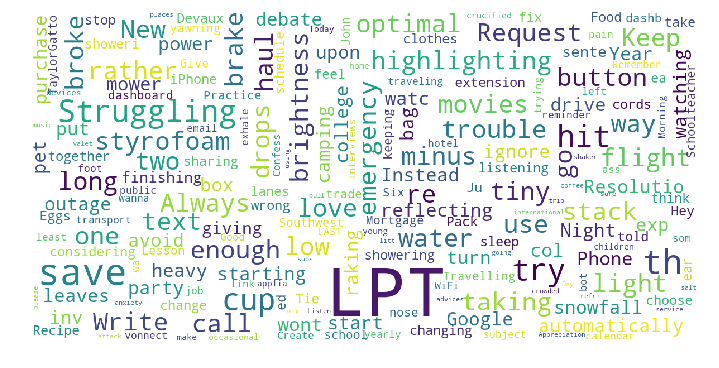

In [28]:
show_wordcloud(lpt["title"])

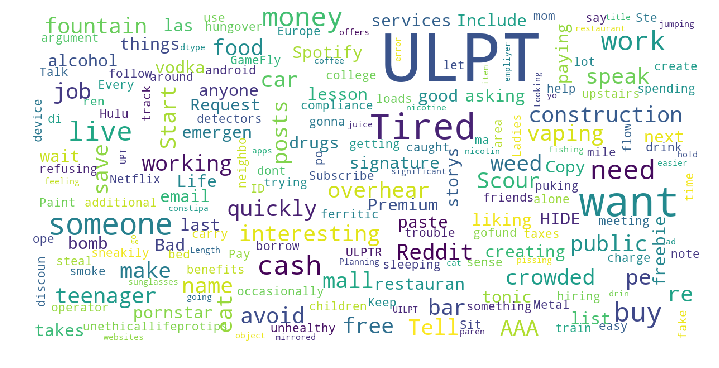

In [29]:
show_wordcloud(ulpt["title"])

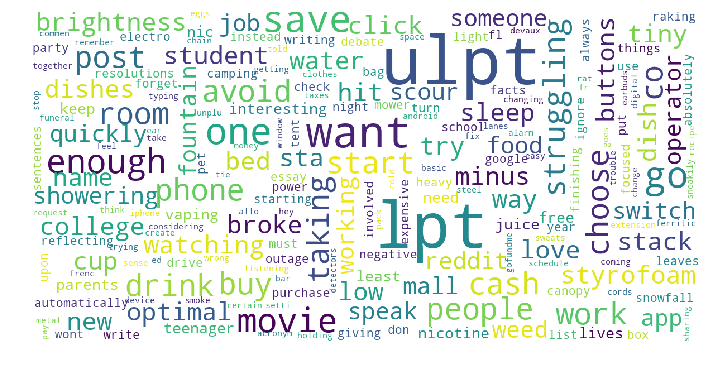

In [30]:
show_wordcloud(tips["title"])

## Measure the baseline before we start

In [31]:
tips["subreddit"].value_counts(normalize=True)

1    0.501057
0    0.498943
Name: subreddit, dtype: float64

### Train/Test Split our Data

- We have to split our given data so that we have something to test against because we scrapped the information from the web and this isn't a Kaggle competition

In [32]:
X = title_feature_cv                                    # Data Frame with CounteVectorizers
X2 = title_feature_tv                                   # Data Frame with TfidfVectorizers
X3 = title_feature_cv.drop(columns=["ulpt", "lpt"])     # Data Frame with CounteVectorizers with the ulpt and lpt columns dropped
X4 = title_feature_tv.drop(columns=["ulpt", "lpt"])     # Data Frame with TfidfVectorizers with the ulpt and lpt columns dropped
y = tips["subreddit"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y)

In [35]:
X3_train, X3_test, y3_train, y4_test = train_test_split(X3, y)

In [36]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y)

### We will be testing out our data sets on three different models.

1. Logisitic Regression
2. RandomForrest Regression

#### Logistic Regression

Will perform a simple LogisticRegression without the hyperparameters first to see what the inital score will be

- X_train will be the CountVectorizer data
- X2_Train will be the TfidfVectorizer


In [37]:
logreg = LogisticRegression()
cross_val_score(logreg, X_train, y_train).mean()

0.9244205661154181

In [38]:
logreg = LogisticRegression()
cross_val_score(logreg, X2_train, y2_train).mean()

0.9339506964822469

In [39]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

gsc = GridSearchCV(logreg, param_grid=params, cv=kf)

gsc.fit(X_train,y_train)

print(gsc.best_score_)
gsc.best_params_

0.9288495100013424


{'C': 1.0, 'class_weight': None, 'penalty': 'l2'}

In [40]:
gsc.score(X_test, y_test)

0.9219001610305958

In [43]:
predictions = gsc.predict(X_test)
    
print(pd.crosstab(y_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
print('Overall accuracy:', accuracy_score(y_test, predictions))

Predicted     0     1   All
Actual                     
0          1130   123  1253
1            71  1160  1231
All        1201  1283  2484 

Overall accuracy: 0.9219001610305958


In [44]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

gsc2 = GridSearchCV(logreg, param_grid=params, cv=kf)

gsc2.fit(X2_train,y2_train)

print(gsc2.best_score_)
gsc2.best_params_

0.9334138810578602


{'C': 1.0, 'class_weight': None, 'penalty': 'l2'}

In [45]:
gsc2.score(X2_test, y2_test)

0.9367954911433173

In [48]:
predictions = gsc2.predict(X2_test)
    
print(pd.crosstab(y2_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
print('Overall accuracy:', accuracy_score(y2_test, predictions))

Predicted     0     1   All
Actual                     
0          1134    92  1226
1            65  1193  1258
All        1199  1285  2484 

Overall accuracy: 0.9367954911433173


#### RandomForrest Classifer

Start with a simple RandomForestClassifier to see what the in initial scores are for the CountVectorizer and TfidfVectorizer

- X_train is our training data based on the CountVectorizer
- X2_train is our training data based on the TfidfVectorizer

In [49]:
rf = RandomForestClassifier()
cross_val_score(rf, X_train, y_train).mean()

0.9214685008763555

In [50]:
rf = RandomForestClassifier()
cross_val_score(rf, X2_train, y2_train).mean()

0.919316182132857

In [54]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2,3,4]
}
gs3 = GridSearchCV(rf, param_grid=rf_params)
gs3.fit(X_train, y_train)
print(gs.best_score_)
gs3.best_params_

0.9334138810578602


{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 20}

In [55]:
gs3.score(X_test, y_test)

0.9323671497584541

In [56]:
predictions = gs3.predict(X_test)
    
print(pd.crosstab(y_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
print('Overall accuracy:', accuracy_score(y_test, predictions))

Predicted     0     1   All
Actual                     
0          1154    99  1253
1            69  1162  1231
All        1223  1261  2484 

Overall accuracy: 0.9323671497584541


In [58]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2,3,4]
}
gs4 = GridSearchCV(rf, param_grid=rf_params)
gs4.fit(X2_train, y2_train)
print(gs4.best_score_)
gs4.best_params_

0.9272385555108068


{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 30}

In [59]:
gs4.score(X2_test, y2_test)

0.9388083735909822

In [60]:
predictions = gs4.predict(X2_test)
    
print(pd.crosstab(y2_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
print('Overall accuracy:', accuracy_score(y2_test, predictions))

Predicted     0     1   All
Actual                     
0          1125   101  1226
1            51  1207  1258
All        1176  1308  2484 

Overall accuracy: 0.9388083735909822


### Initial Findings

- Based on the findings it would appear that a Logistic Regression utilizing the RidgeCV and the TfidfVectorizer models our data teh best. 

- Interesting note that the RandomForest Clssifier had a large difference in modeling cabailities based on whether it was countvectorizer or a TfidiFVectorizer. 

    - The bet results for a random forest were the TfidifVectorizer with the RandomForest Classifers

### A Deeper Dive

- One the underlying requirements for a post on LifeProTips and UnethicalLifeProTips is that they have to the LPT and ULPT tag in the title

- We will examine the models again this time taking out the ULPT and LPT column in both vectorizing methods and model it again to see if that has an impact on our data

In [61]:
logreg = LogisticRegression()
cross_val_score(logreg, X3_train, y3_train).mean()

0.7688280306081353

In [62]:
logreg = LogisticRegression()
cross_val_score(logreg, X4_train, y4_train).mean()

0.7634585357939621

In [63]:
rf = RandomForestClassifier()
cross_val_score(rf, X3_train, y3_train).mean()

0.7442609746274668

In [64]:
rf = RandomForestClassifier()
cross_val_score(rf, X4_train, y4_train).mean()

0.7355359699780007

# Executive Summary

- Provide the subreddits used in our data set we were able to creat an accruate model with our dataset
    - Given the rules of the subreddit, the each model we used had a score around .94 and the test and train data was close. 
    - The rules for the subreddit are that they have to LPT and ULPT for the title. 
    - The best models were 
        - TfidfVectorizers
        - In combination with LogisticRegression using Ridge
        - The second best combination was with the same vectorizer and RandomForrest but the RandomForrest did not have overfitting similiar to the Logistic REgression using Ridge

- When the LPT and ULPT columns were taken out to just examine the body of the text to see how well he model fits, The LogisticRegressor with CountVectorizer did the best but overall there was a .20 decrease in the score of the model. 

- The model did do better than the baseline predictor which was 50/50